<a href="https://colab.research.google.com/github/gabitoju/ORT/blob/master/Graph_Convolutions_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convoluciones

Este notebook presenta una simulación paso a paso de el operador convolucional definido en [T. N. Kipf and M. Welling](https://arxiv.org/abs/1609.02907). Cada capa convolucional sigue la siguiente regla de propagación:

\\begin{equation}
    Z = \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}X\Theta
\end{equation}

Donde $\tilde{A}$ es la matriz de adyacencia con auto-relaciones, $\tilde{D}$ es la matriz de grado de $\tilde{A}$, $X$ la matriz de _features_ de los vértices y $\Theta$ una matriz de filtros del _kernel_.

En esta demo no serán usadas las autorelaciones por lo cuál se tendrá $D$ y $A$.

La demostración será realizada usando un grafo no dirigido de 3 vértices y dos ariastas como el que se presenta en la siguiente figura.

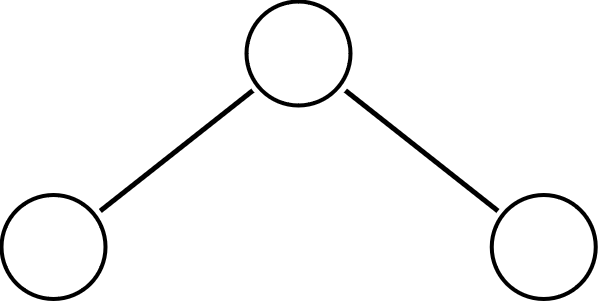

Tanto A como X y W son parametrizables por lo cual este ejercicio puede ser extendido a grafos más complejos. Por tratarse de un ejercicio puramente educativo es recomendable usar grafos y parámetros pequeños para entender mejor el paso a paso de la convolución.

## Funciones

In [1]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
%matplotlib inline

### Auxiliares

In [4]:
def create_attributes(x):
    attrs = {}

    if len(x[0].shape) == 0:
        for ix, value in enumerate(x):
            attrs[ix] = {"x": f"x: {round(value.item(), 2)}"}
    else:
        for ix, value in enumerate(x):
            s = ''
            for v in value:
                s += str(round(v.item(), 4)) + '\n'
            attrs[ix] = {"x": f"x: {s}"}

    return attrs

In [5]:
def draw_graph(fig, g, attrs, k, axes, is_matrix_x, clear=False):
    nx.set_node_attributes(g, attrs)
    labels = nx.get_node_attributes(g, 'x')
    if not is_matrix_x:
        nx.draw_circular(g, ax=axes[k], with_labels = True, labels=labels, node_size=2000, font_color="whitesmoke", alpha=0.95)
    else:
        nx.draw_circular(g, ax=axes[k], with_labels = True, labels=labels, node_size=2000, font_size=10, alpha=0.95, font_weight="bold")
    axes[k].set_title(f'K = {k}')

    if k > 0:
        display(fig)
    plt.show()
    if clear:
        clear_output(wait=True)
        time.sleep(2)

### Convoluciones

In [6]:
def get_laplacian(adj):
    rowsum = A.sum(axis=1)
    D = torch.zeros(adj.shape)

    for ix, value in enumerate(rowsum):
        D[ix][ix] = value

    return D - A

In [7]:
def get_norm_laplacian(lap):
    inv_sqrt = lap.pow(-0.5)
    inv_sqrt = inv_sqrt.masked_fill_(inv_sqrt == float('inf'), 0).nan_to_num()

    return inv_sqrt

In [8]:
def conv(A, H, W):
    L = get_laplacian(A)
    nl = get_norm_laplacian(L)
    dad = torch.mm(torch.mm(nl, A), nl)
    message = dad.matmul(H).matmul(W)
    return message

In [9]:
def forward(A, X, W):
    x = conv(A, X, W)
    x = F.relu(x)

    return x

In [10]:
def generate_messages(A, X, W, K, is_matrix_x=False):
    H = X
    fig, axes = plt.subplots(1, K + 1, figsize=(25, 5))
    G = nx.from_numpy_array(A.numpy())
    attrs = create_attributes(X)
    draw_graph(fig, G, attrs, 0, axes, is_matrix_x, True)

    for i in range(K):
        H = forward(A, H, W)
        attrs = create_attributes(H)
        nx.set_node_attributes(G, attrs)

        if (i + 1) < K:
            draw_graph(fig, G, attrs, i + 1, axes, is_matrix_x, True)
        else:
            draw_graph(fig, G, attrs, i + 1, axes, is_matrix_x)
    plt.tight_layout()

## Demo

### Parametrización

In [22]:
A = torch.tensor([[0., 1., 0.], [1., 0., 1.], [0., 1., 0.]])
X = torch.tensor([1., 2., 3.])
W = torch.eye(A.size(dim=0))

### K = 2 y parámetros default

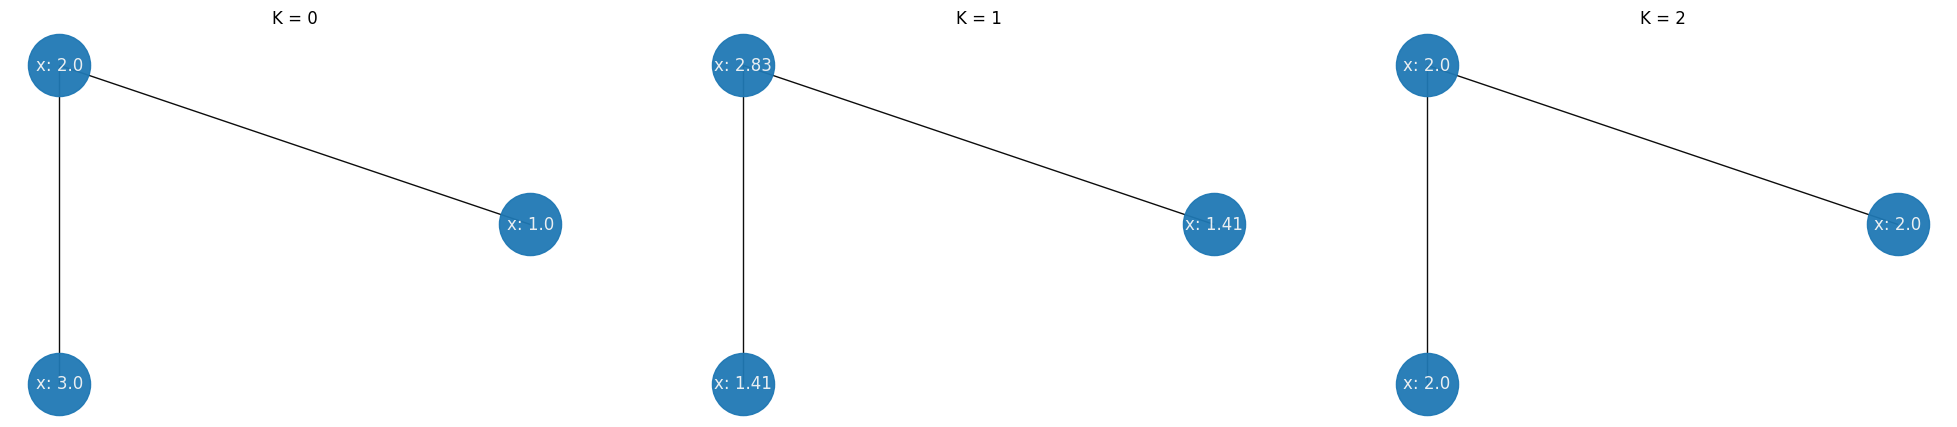

<Figure size 640x480 with 0 Axes>

In [12]:
K = 2
generate_messages(A, X, W, K)

### K variable y W aleatorio

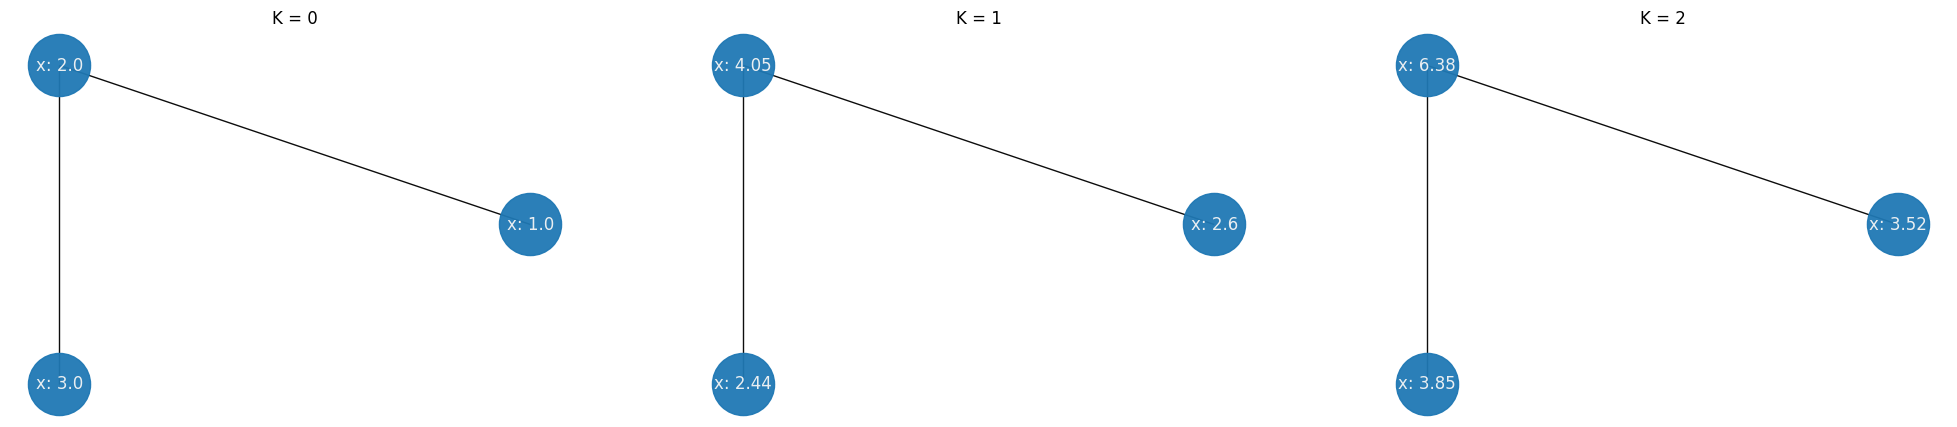

<Figure size 640x480 with 0 Axes>

In [15]:
K = 2
w = torch.rand(A.shape)
generate_messages(A, X, w, K)

### K variable, W y X aleatorios

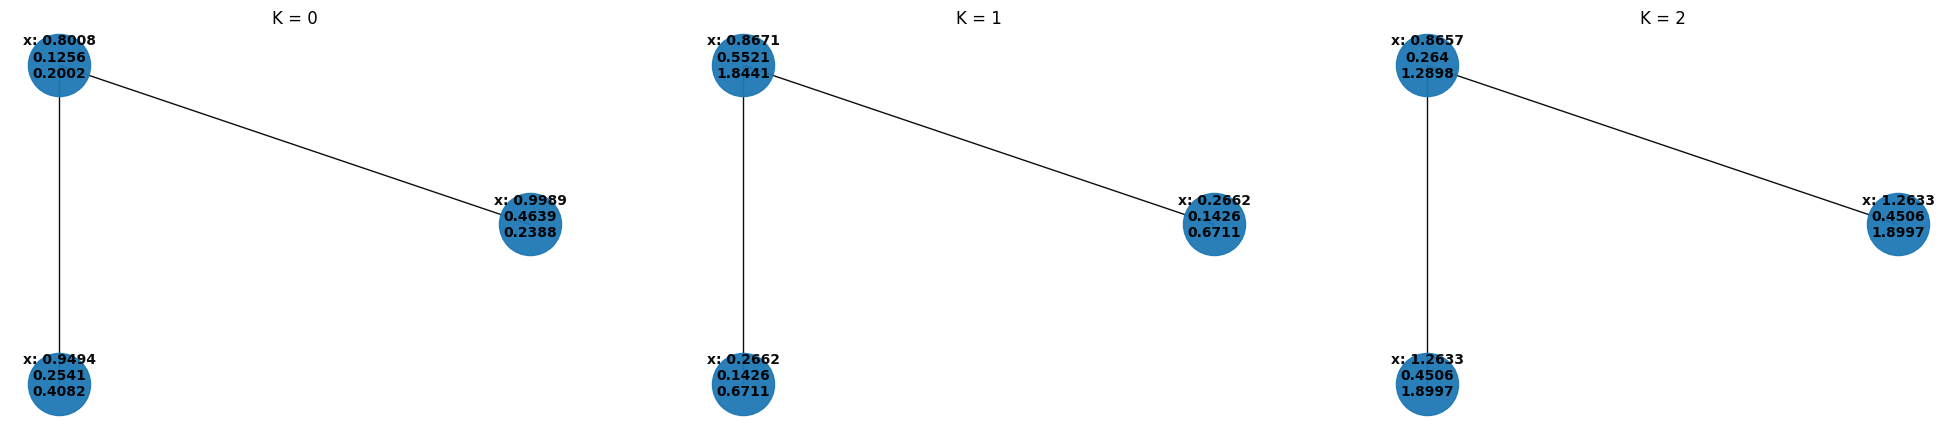

<Figure size 640x480 with 0 Axes>

In [23]:
K = 2
w = torch.rand(A.shape)
x = torch.rand(A.shape)
generate_messages(A, x, w, K, True)

### A + I (self loops)

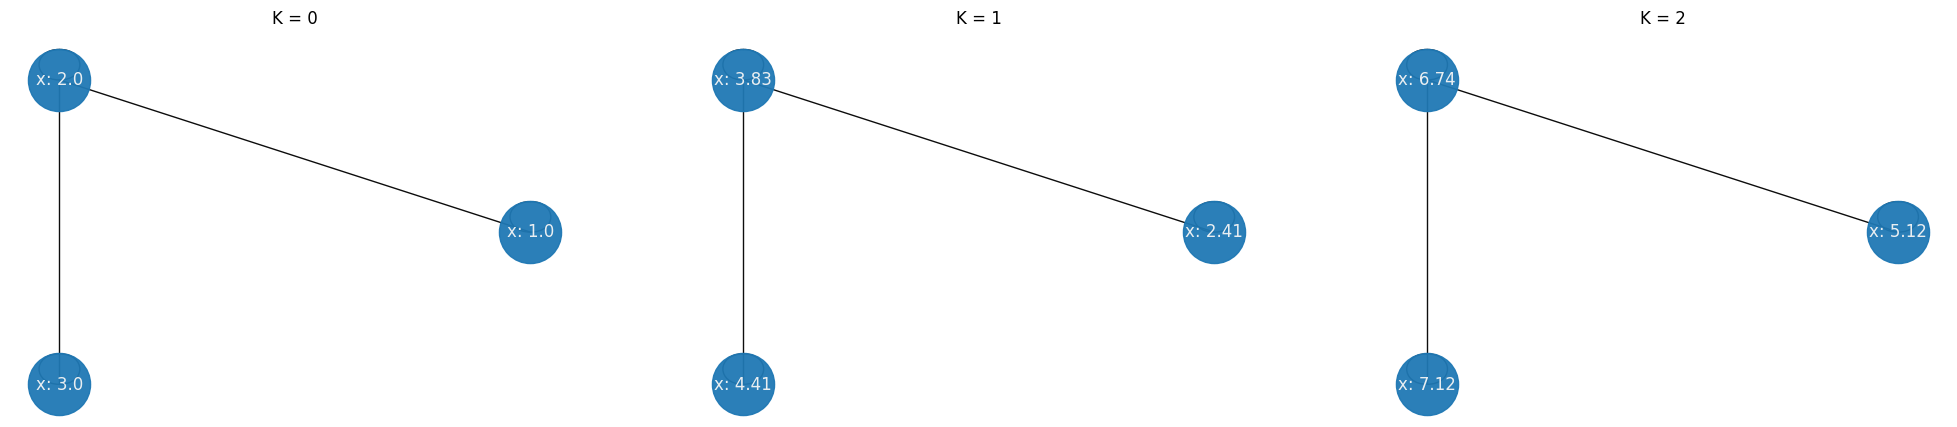

<Figure size 640x480 with 0 Axes>

In [21]:
K = 2
I = torch.eye(A.size(dim=0))
generate_messages(A + I, X, W, K)